## Deep Learning Course (980)
## Assignment Four 

__Assignment Goals__:

- Implementing Fully Connected AutoEncoders
- Implementing Convolutional AutoEncoders
- Understand Variational Autoncoder intuition


In this assignment, you will be asked to design a Fully Connected and a CNN AutoEncoder. With a simple change in your Fully Connected AutoEncoder, you will become more familiar with Variational AutoEncoder. 

__DataSet:__ In this Assignment, you will use the MNIST handwritten digit database. You can use  (x_train, _), (x_test, _)  = tensorflow.keras.datasets.mnist.load_data() to load the dataset.

1. (30 points) Implement a Fully Connected AutoEncoder in TensorFlow (cf. Chapter 7). Your AutoEncoder should have a bottleneck with two neurons and Mean Squared Error (MSE) as the objective function. In an AutoEncoder, the layer with the least number of neurons is referred to as a bottleneck. Train your model on MNIST. Plot the train and test loss. Randomly select 10 images from the test set, encode them and visualize the decoded images.
     
2. (35 points) Implement a convolutional AutoEncoder (CAE) that uses only the following types of layers: convolution, pooling, upsampling and transpose. You are limited to use MSE. The encoder and decoder should include one or more layers, with the size and number of filters chosen by you. Start with a bottleneck of size 2, train your model on MNIST and plot the train and test loss. Randomly select 10 images from the test set, encode them and visualize the decoded images. Are the reconstructed images readable for humans? If not, try to find a CAE architecture, including a larger bottleneck, that is powerful enough to generate readable images. The bottleneck should be as small as possible for readability, this is part of the grading criteria.

3. (35 points) This question is about using an AutoEncoder to generate similar but not identical hand digits. We use a naive approach: Try to see if a trained decoder can map randomly generated inputs (random numbers) to a recognizable hand-written digit. 
    1. Start with your Fully Connected and trained AutoEncoder from part 1. Try to generate new images by inputting some random numbers  to the decoder (i.e. the bottleneck layer) and report your results. Hint: This is not easy. You probably want to input at least 10 random numbers. 
    2. Now restrict the AutoEncoder hidden bottleneck layer(s) to have a standard multi-variate normal distribution with mean zeroes and the identity matrix as variance (i.e. no correlations). Retrain the Fully Connected AutoEncoder with the normalized bottleneck. Now randomly generate inputs to the bottleneck layer that are drawn from the multi-variate standard normal distribution, and use the random inputs to generate new images. Report your result.
    3. Are the output images different between 1) and 2)? If so, why do you think this difference occurs?

4. (20 points) Optional: change the AutoEncoder which you developed in the last part of section 3 so that it becomes a Variational AutoEncoder (Introduced by Kingma 2014; see Chapter 7.1). Does the VAE produce a different quality of output image?



__Submission Notes__:

Please use Jupyter Notebook. The notebook should include the final code, results, and answers. You should submit your Notebook in .pdf and .ipynb format. (penalty 10 points).
Your AutoEncoders should have only one bottleneck.
 



__Instructions__:

The university policy on academic dishonesty and plagiarism (cheating) will be taken very seriously in this course. Everything submitted should be your writing or coding. You must not let other students copy your work. Spelling and grammar count.



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers
from keras.callbacks import CSVLogger, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Load data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (60000, 784)
x_test shape:  (10000, 784)


In [3]:
# Build model
intermidiate1_dim = 32
intermidiate2_dim = 16
latent_dim = 2

input_dim = x_train.shape[1] # 784

# Encoder
input_img = Input(shape=(input_dim,))
x = Dense(intermidiate1_dim, activation='relu')(input_img)
x = Dense(intermidiate2_dim, activation='relu')(x)
encoded = Dense(latent_dim, activation='relu')(x)

fc_encoder = Model(input_img, encoded, name='fc_encoder')
fc_encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermidiate2_dim, activation='relu')(latent_inputs)
x = Dense(intermidiate1_dim, activation='relu')(x)
decoded = Dense(input_dim, activation='sigmoid')(x)

fc_decoder = Model(latent_inputs, decoded, name='fc_decoder')
fc_decoder.summary()

# FC-autoencoder
outputs = fc_decoder(fc_encoder(input_img))
fc_autoencoder = Model(input_img, outputs, name='fc_autoencoder')
fc_autoencoder.summary()

Model: "fc_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,682
Trainable params: 25,682
Non-trainable params: 0
_________________________________________________________________
Model: "fc_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
________________________________

In [4]:
# Training
result_root_folder = 'fc_autoencoder'
checkpointer = ModelCheckpoint(
        filepath=result_root_folder+'/epoch-{epoch:02d}-accu-{val_accuracy:.4f}.hdf5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True, mode='auto', period=10)
logfile = CSVLogger(result_root_folder+'/train.log', append=False, separator=',')
# adam = keras.optimizers.Adam(lr=0.001)
fc_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = fc_autoencoder.fit(x_train, x_train,
        batch_size=256,
        epochs=3,#50,
        verbose=1,
        callbacks=[checkpointer, logfile],
        shuffle=True,
        validation_data=(x_test, x_test),
        workers=4)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 1s 23us/step - loss: 0.0889 - accuracy: 0.0086 - val_loss: 0.0674 - val_accuracy: 0.0151
Epoch 2/3
60000/60000 [==============================] - 1s 19us/step - loss: 0.0629 - accuracy: 0.0108 - val_loss: 0.0602 - val_accuracy: 0.0129
Epoch 3/3
60000/60000 [==============================] - 1s 18us/step - loss: 0.0591 - accuracy: 0.0115 - val_loss: 0.0573 - val_accuracy: 0.0189


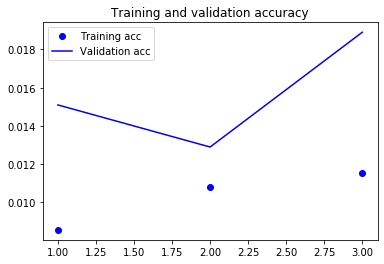

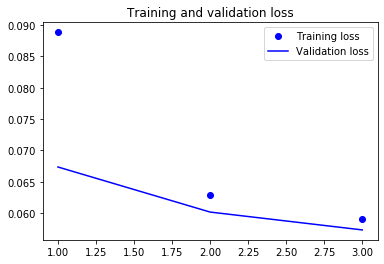

In [5]:
# Displaying curves of loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(result_root_folder+'/accuracy.png')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(result_root_folder+'/loss.png')

(10,)


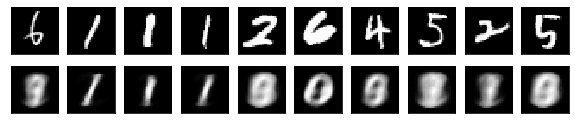

In [6]:
# Randomly select 10 images from the test set, encode them and visualize the decoded images.
np.random.seed(0)
n = 10
decoded_images = fc_autoencoder.predict(x_test)

rand_indices = np.random.randint(x_test.shape[0], size=n)
print(rand_indices.shape)
plt.figure(figsize=(10, 2))
plt.gray()
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[rand_indices[i]].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(decoded_images[rand_indices[i]].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

2. (35 points) Implement a convolutional AutoEncoder (CAE) that uses only the following types of layers: convolution, pooling, upsampling and transpose. You are limited to use MSE. The encoder and decoder should include one or more layers, with the size and number of filters chosen by you. Start with a bottleneck of size 2, train your model on MNIST and plot the train and test loss. Randomly select 10 images from the test set, encode them and visualize the decoded images. Are the reconstructed images readable for humans? If not, try to find a CAE architecture, including a larger bottleneck, that is powerful enough to generate readable images. The bottleneck should be as small as possible for readability, this is part of the grading criteria.

In [7]:
# Part 2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
from keras.callbacks import CSVLogger, ModelCheckpoint

In [8]:
# Load data if not already loaded
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [9]:
# Build model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(encoded.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = Model(input_img, outputs, name='conv_autoencoder')
conv_autoencoder.summary()

(None, 4, 4, 8)
Model: "conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None

In [10]:
# Training
result_root_folder = 'conv_autoencoder'
checkpointer = ModelCheckpoint(
        filepath=result_root_folder+'/epoch-{epoch:02d}-accu-{val_accuracy:.4f}.hdf5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True, mode='auto', period=10)
logfile = CSVLogger(result_root_folder+'/train.log', append=False, separator=',')
# adam = keras.optimizers.Adam(lr=0.001)
conv_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = conv_autoencoder.fit(x_train, x_train,
        batch_size=256,
        epochs=3,#50,
        verbose=1,
        callbacks=[checkpointer, logfile],
        shuffle=True,
        validation_data=(x_test, x_test),
        workers=4)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 32s 531us/step - loss: 0.1248 - accuracy: 0.7987 - val_loss: 0.1140 - val_accuracy: 0.8072
Epoch 2/3
60000/60000 [==============================] - 35s 577us/step - loss: 0.1120 - accuracy: 0.8088 - val_loss: 0.1140 - val_accuracy: 0.8072
Epoch 3/3
60000/60000 [==============================] - 36s 595us/step - loss: 0.1120 - accuracy: 0.8088 - val_loss: 0.1140 - val_accuracy: 0.8072


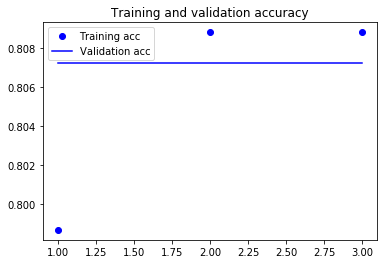

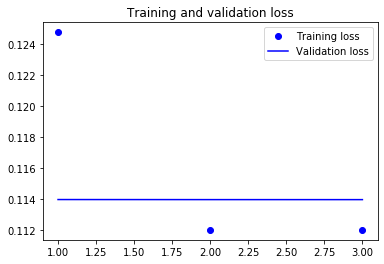

In [11]:
# Displaying curves of loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(result_root_folder+'/accuracy.png')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(result_root_folder+'/loss.png')

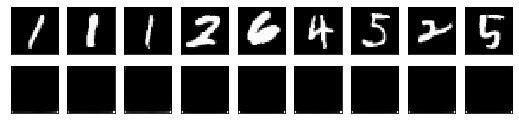

In [12]:
# Randomly select 10 images from the test set, encode them and visualize the decoded images.
np.random.seed(0)
n = 10
decoded_images = conv_autoencoder.predict(x_test)

rand_indices = np.random.randint(x_test.shape[0], size=n)
plt.figure(figsize=(10, 2))
plt.gray()
for i in range(1, n):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[rand_indices[i]].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n + i)
    plt.imshow(decoded_images[rand_indices[i]].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

3. (35 points) This question is about using an AutoEncoder to generate similar but not identical hand digits. We use a naive approach: Try to see if a trained decoder can map randomly generated inputs (random numbers) to a recognizable hand-written digit. 
    1. Start with your Fully Connected and trained AutoEncoder from part 1. Try to generate new images by inputting some random numbers  to the decoder (i.e. the bottleneck layer) and report your results. Hint: This is not easy. You probably want to input at least 10 random numbers. 
    2. Now restrict the AutoEncoder hidden bottleneck layer(s) to have a standard multi-variate normal distribution with mean zeroes and the identity matrix as variance (i.e. no correlations). Retrain the Fully Connected AutoEncoder with the normalized bottleneck. Now randomly generate inputs to the bottleneck layer that are drawn from the multi-variate standard normal distribution, and use the random inputs to generate new images. Report your result.
    3. Are the output images different between 1) and 2)? If so, why do you think this difference occurs?

[[5 0]
 [3 3]
 [7 9]
 [3 5]
 [2 4]
 [7 6]
 [8 8]
 [1 6]
 [7 7]
 [8 1]]


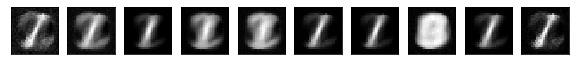

In [13]:
# Part 3A
# encoded_images = fc_encoder.predict(x_test)
# print(encoded[0:10])

np.random.seed(0)
n = 10
rand_nums = np.random.randint(10, size=(n, 2))
print(rand_nums)
decoded_images = fc_decoder.predict(rand_nums)

plt.figure(figsize=(n, 1))
plt.gray()

for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(decoded_images[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
# Part 3B
import tensorflow as tf
import numpy as np
# from scipy.stats import norm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras import backend as K
from keras.callbacks import CSVLogger, ModelCheckpoint

In [15]:
# Load data if not loaded
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (60000, 784)
x_test shape:  (10000, 784)


In [20]:
# Build model
input_dim = x_train.shape[1] # 784
intermidiate1_dim = 32
intermidiate2_dim = 16
latent_dim = 2

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder
input_img = Input(shape=(input_dim,))
x = Dense(intermidiate1_dim, activation='relu')(input_img)
x = Dense(intermidiate2_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

fc_norm_encoder = Model(input_img, z, name='fc_norm_encoder')
fc_norm_encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermidiate2_dim, activation='relu')(latent_inputs)
x = Dense(intermidiate1_dim, activation='relu')(x)
decoded = Dense(input_dim, activation='sigmoid')(x)

fc_norm_decoder = Model(latent_inputs, decoded, name='fc_norm_decoder')
fc_norm_decoder.summary()

# FC-normalized-autoencoder
outputs = fc_norm_decoder(fc_norm_encoder(input_img))
fc_norm_autoencoder = Model(input_img, outputs, name='fc_autoencoder')
fc_norm_autoencoder.summary()

Model: "fc_norm_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 32)           25120       input_11[0][0]                   
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 16)           528         dense_32[0][0]                   
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 2)            34          dense_33[0][0]                   
____________________________________________________________________________________

In [21]:
# Training
result_root_folder = 'fc_norm_autoencoder'
checkpointer = ModelCheckpoint(
        filepath=result_root_folder+'/epoch-{epoch:02d}-accu-{val_accuracy:.4f}.hdf5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True, mode='auto', period=10)
logfile = CSVLogger(result_root_folder+'/train.log', append=False, separator=',')
# adam = keras.optimizers.Adam(lr=0.001)
fc_norm_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = fc_norm_autoencoder.fit(x_train, x_train,
        batch_size=256,
        epochs=3,#50,
        verbose=1,
        callbacks=[checkpointer, logfile],
        shuffle=True,
        validation_data=(x_test, x_test),
        workers=4)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 1s 23us/step - loss: 0.0862 - accuracy: 0.0093 - val_loss: 0.0662 - val_accuracy: 0.0137
Epoch 2/3
60000/60000 [==============================] - 1s 20us/step - loss: 0.0639 - accuracy: 0.0095 - val_loss: 0.0618 - val_accuracy: 0.0077
Epoch 3/3
60000/60000 [==============================] - 1s 19us/step - loss: 0.0605 - accuracy: 0.0094 - val_loss: 0.0591 - val_accuracy: 0.0068


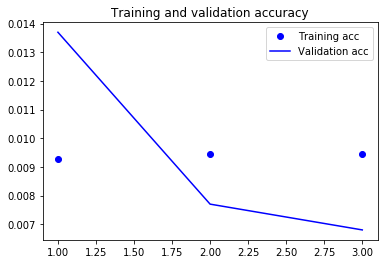

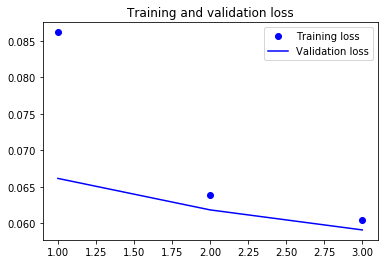

In [22]:
# Displaying curves of loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(result_root_folder+'/accuracy.png')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(result_root_folder+'/loss.png')

[[0.         0.39894228]
 [0.11111111 0.39648726]
 [0.22222222 0.38921247]
 [0.33333333 0.37738323]
 [0.44444444 0.36142383]
 [0.55555556 0.34189229]
 [0.66666667 0.31944801]
 [0.77777778 0.29481487]
 [0.88888889 0.26874286]
 [1.         0.24197072]]


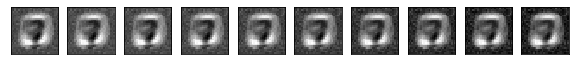

In [23]:
# Visualize the generated images.
np.random.seed(0)
n = 10
x = np.linspace(0, 1, n).reshape(n, 1)
y = multivariate_normal.pdf(x, mean=0, cov=1.0).reshape(n, 1);
rand_nums = np.concatenate((x, y), axis=1)
print(rand_nums)

decoded_images = fc_norm_decoder.predict(rand_nums)

plt.figure(figsize=(n, 1))
plt.gray()
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(decoded_images[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
# Part 3C
# Are the output images different between 1) and 2)? If so, why do you think this difference occurs?

4. (20 points) Optional: change the AutoEncoder which you developed in the last part of section 3 so that it becomes a Variational AutoEncoder (Introduced by Kingma 2014; see Chapter 7.1). Does the VAE produce a different quality of output image?

In [1]:
import tensorflow as tf
import numpy as np
# from scipy.stats import norm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.callbacks import CSVLogger, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Load data if not loaded
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (60000, 784)
x_test shape:  (10000, 784)


In [41]:
# Build model
input_dim = x_train.shape[1] # 784
intermidiate1_dim = 32
intermidiate2_dim = 16
latent_dim = 2

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder
input_img = Input(shape=(input_dim,))
x = Dense(intermidiate1_dim, activation='relu')(input_img)
x = Dense(intermidiate2_dim, activation='relu')(x)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

vae_encoder = Model(input_img, [z_mean, z_log_var, z], name='vae_encoder')
vae_encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermidiate2_dim, activation='relu')(latent_inputs)
x = Dense(intermidiate1_dim, activation='relu')(x)
decoded = Dense(input_dim, activation='sigmoid')(x)

vae_decoder = Model(latent_inputs, decoded, name='vae_decoder')
vae_decoder.summary()

# VAE model
outputs = vae_decoder(vae_encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')
vae.summary()

Model: "vae_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_132 (Dense)               (None, 32)           25120       input_39[0][0]                   
__________________________________________________________________________________________________
dense_133 (Dense)               (None, 16)           528         dense_132[0][0]                  
__________________________________________________________________________________________________
dense_134 (Dense)               (None, 2)            34          dense_133[0][0]                  
________________________________________________________________________________________

In [42]:
# Train
result_root_folder = 'vae'
checkpointer = ModelCheckpoint(
        filepath=result_root_folder+'/epoch-{epoch:02d}-accu-{val_accuracy:.4f}.hdf5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True, mode='auto', period=10)
logfile = CSVLogger(result_root_folder+'/train.log', append=False, separator=',')

# Compute VAE loss = mse_loss/xent_loss + kl_loss
xent_loss = input_dim * binary_crossentropy(input_img, outputs)
# mse_loss = input_dim * mse(input_img, outputs)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

# adam = keras.optimizers.Adam(lr=0.001)
vae.compile(optimizer='adam', metrics=['accuracy'])

history = vae.fit(x_train,
        batch_size=128,
        epochs=1,#50,
        verbose=1,
        callbacks=[checkpointer, logfile],
        shuffle=True,
        validation_data=(x_test, None),
        workers=4)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 34us/step - loss: 228.9027 - val_loss: 190.9836


[[0.         0.39894228]
 [0.11111111 0.39648726]
 [0.22222222 0.38921247]
 [0.33333333 0.37738323]
 [0.44444444 0.36142383]
 [0.55555556 0.34189229]
 [0.66666667 0.31944801]
 [0.77777778 0.29481487]
 [0.88888889 0.26874286]
 [1.         0.24197072]]


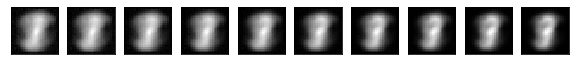

In [40]:
# Visualize the generated images.
np.random.seed(0)
n = 10
x = np.linspace(0, 1, n).reshape(n, 1)
y = multivariate_normal.pdf(x, mean=0, cov=1.0).reshape(n, 1);
# x = norm.ppf(np.linspace(0.05, 0.95, n)).reshape(n, 1)
# y = norm.ppf(np.linspace(0.05, 0.95, n)).reshape(n, 1)
z_sample = np.concatenate((x, y), axis=1)
print(z_sample)

decoded_images = vae_decoder.predict(z_sample)

plt.figure(figsize=(n, 1))
plt.gray()
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(decoded_images[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()